In [9]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt 

In [10]:
bins = np.arange(11)
bin_cents = (bins[1:]+bins[:-1])/2

hist1 = np.array([1.5, 3., 6., 7.5, 6.3, 6.6, 5.5, 2.5, 3. , 1.5])
hist1_err = np.array([0.4 , 0.4 , 0.3 , 0.2 , 0.15, 0.4 , 0.45, 0.5 , 0.3 , 0.35])
hist2 = np.array([3. , 6., 9., 12., 15., 9. , 6., 3. , 3.3, 2.15])
hist2_err = np.array([1. , 1. , 3. , 2. , 2., 1. , 2., 2. , 1. , 1.])


data = np.array([ 4, 17, 26, 23, 34, 23, 21,  7,  8,  4])

In [11]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu1", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

# info: the `poi_name=None` is nescessary here since we don't want to do a hypothesis test
model = pyhf.Model(spec, poi_name=None)

[1, 1.0, 1.0]


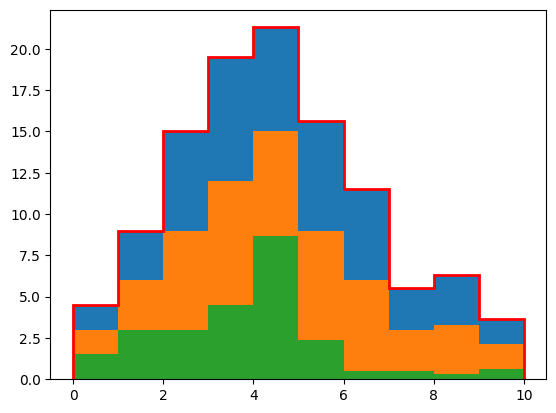

In [12]:
plt.stairs(hist1+hist2, bins, baseline=hist2, fill = True)
plt.stairs(hist2, bins, fill=True)
plt.stairs(hist2-hist1, bins, fill=True)


initial_parameters = model.config.suggested_init()
initial_parameters[0] = 1
# initial_parameters[1] = 1

plt.stairs(model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')
# plt.errorbar(bin_cents, model.config.auxdata, yerr=np.sqrt(model.config.auxdata), fmt='o')
print(initial_parameters)


# Correlations within sample

In [353]:
from copy import deepcopy

def _pca(corr, return_rot=False):
    """Principal Component analysis, moving to a space where the covariance matrix is diagonal
    https://www.cs.cmu.edu/~elaw/papers/pca.pdf

    Args:
        cov (array): Correlation matrix

    Returns:
        array: matrix of column wise error vectors (eigenvectors * sqrt(eigenvalues); sqrt(eigenvalues) = std)
    """
    svd = np.linalg.svd(corr)
    uvec = svd[0] @ np.sqrt(np.diag(svd[1]))
    if return_rot:
        return uvec, svd[0]
    return uvec

def validate(corr):
    for c in corr:
        shape = np.shape(c["corr"])
        if len(shape) != 2:
            raise ValueError("Correlation matrix must be 2-dimensional.")
        if shape[0] != shape[1]:
            raise ValueError("Correlation matrix must be square.")
        if len(c["vars"]) != len(c["corr"]):
            raise ValueError("Number of variables does not match dimension of correlation matrix")
        
class _corr_mod:
    def __init__(self, i_ch = None, i_sa = None, nominal = None, hi_shift = None, lo_shift = None):
        self.i_ch = i_ch
        self.i_sa = i_sa
        self.nom = nominal
        self.lo_shift = lo_shift if lo_shift else np.zeros(len(nominal))
        self.hi_shift = hi_shift if hi_shift else np.zeros(len(nominal))
        
        
def get_coords(var_name, spec):
    for ich, ch in enumerate(spec):
        for isa, sa in enumerate(ch["samples"]):
            for imo, mo in enumerate(sa["modifiers"]):
                if mo["name"] == var_name:
                    return ich, isa, imo
    

def decorrelate(spec):
    if "correlations" in spec.keys():
        print("correlation found")
        
        validate(spec["correlations"])
        
        spec = deepcopy(spec)
        
        for corr in spec["correlations"]:
            
            # compute decorrelation 
            uvec = _pca(corr["corr"])
            
            # get channel, sample and modifier index for each variable
            coords = []
            for var in corr["vars"]:
                coords.append(get_coords(var, spec["channels"]))

            mod_type  = [spec["channels"][c[0]]["samples"][c[1]]["modifiers"][c[2]]["type"] for c in coords]
            mod_type  = np.unique(mod_type)[0]
            
            #check if all modifiers have the same type
            if mod_type.size != 1:
                raise ValueError("Correlated modifiers must have the same type.")
            
            nom       = np.array([spec["channels"][c[0]]["samples"][c[1]]["data"] for c in coords])
            lo_diffs  = np.array([np.subtract(spec["channels"][c[0]]["samples"][c[1]]["modifiers"][c[2]]["data"]["lo_data"], n) for c, n in zip(coords, nom)])
            hi_diffs  = np.array([np.subtract(spec["channels"][c[0]]["samples"][c[1]]["modifiers"][c[2]]["data"]["hi_data"], n) for c, n in zip(coords, nom)])
            
            #initialize modifiers
            # mods = []
            # for i_ch in np.unique([c[0] for c in coords]):
            #     for i_sa in np.unique([c[1] for c in coords]):
            #         nom = np.array(spec["channels"][i_ch]["samples"][i_sa]["data"])
            #         mods.append(_corr_mod(i_ch, i_sa, nom))
            
            # for uv in uvec.T:
            #     for u, c in zip(uv, coords):
            #         for mod in mods:
            #             if mod.i_ch == c[0] and mod.i_sa == c[1]:
            #                 lo_diff = np.subtract(spec["channels"][c[0]]["samples"][c[1]]["modifiers"][c[2]]["data"]["lo_data"], mod.nom)
            #                 hi_diff = np.subtract(spec["channels"][c[0]]["samples"][c[1]]["modifiers"][c[2]]["data"]["lo_data"], mod.nom)
            #                 mod.lo_shift += u * lo_diff
            #                 mod.hi_shift += u * hi_diff
                
                
            
            
            lo_shifts = np.array([np.sum(u[:, np.newaxis] * lo_diffs, axis=0) for u in uvec.T])
            hi_shifts = np.array([np.sum(u[:, np.newaxis] * hi_diffs, axis=0) for u in uvec.T])
            
            print(coords)
            print(lo_shifts)
            
            new_lo = [n + s for n, s in zip(nom, lo_shifts)]
            new_hi = [n + s for n, s in zip(nom, hi_shifts)]
            
            # compute shifts depending on channel and sample
            # for each unique channel and sample, add one modifier
            # within one sample, add all contributions
            # for ich in np.unique([c[0] for c in coords]):
            #     for isa in np.unique([c[1] for c in coords]):
                    
            #         nom = spec["channels"][ich]["samples"][isa]["data"]
            #         mask = [[(c[0]==ich and c[1]==isa) for c in coords] for _ in uvec.T]
            #         mask = [[True, False], [True, False]]
            #         print([(c[0]==ich and c[1]==isa) for c in coords])
            #         print(lo_shifts[mask])
            #         print(lo_shifts[mask])
                    
                    # hi_shift = np.zeros(len(nom))
                    # lo_shift = np.zeros(len(nom))
                    # for co, uv in coords, uvec.T:
            #             if co[0] == ich and co[1] == isa:
            #                 imo = co[2]
            #                 lo_shift += np.subtract(spec["channels"][ich]["samples"][isa]["modifiers"][imo]["data"]["lo_data"], nom)
            #                 hi_shift += np.subtract(spec["channels"][ich]["samples"][isa]["modifiers"][imo]["data"]["hi_data"], nom)
                            
                    
            
            # compute new high and low modifications for eigenvector
            
            #add new modifier
            for i, (nl, nh) in enumerate(zip(new_lo, new_hi)):
                for ich in np.unique([c[0] for c in coords]):
                    for isa in np.unique([c[1] for c in coords]):
                        spec["channels"][ich]["samples"][isa]["modifiers"].append(
                            {
                                "name": corr["name"] + f"[{str(i)}]",
                                "type": mod_type,
                                "data": {
                                    "lo_data": list(nl),
                                    "hi_data": list(nh)
                                }
                            }
                        )
            
            #rm old modifier
            new_modifiers = []
            for ich in np.unique([c[0] for c in coords]):
                for isa in np.unique([c[1] for c in coords]):
                    for m in spec["channels"][ich]["samples"][isa]["modifiers"]:
                        if m["name"] not in corr["vars"]:
                            new_modifiers.append(m)
        
        spec["channels"][ich]["samples"][isa]["modifiers"] = new_modifiers
        
        del spec["correlations"]
        
    return spec

In [354]:
# add correlated parameters to pyhf model
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist1),
                    "hi_data": list(hist2+hist1)
                }
            },
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist2),
                    "hi_data": list(hist2+hist2)
                }
            }
        ],
        
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [355]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}
new_spec = decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found
[(0, 0, 1), (0, 0, 2)]
[[ 4.5   9.   15.   19.5  21.3  15.6  11.5   5.5   6.3   3.65]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'corr[0]',
       'type': 'histosys',
       'data': {'lo_data': [7.5,
         15.0,
         24.0,
         31.499999999999996,
         36.3,
         24.599999999999998,
         17.5,
         8.5,
         9.599999999999998,
         5.799999999999999],
        'hi_data': [-1.5,
         -3.0,
         -5.999999999999998,
         -7.4999999999999964,
         -6.299999999999997,
         -6.599999999999998,
         -5.499999999999998,
         -2.499999999999999,
         -2.999999999999999,
         -1.4999999999999996]}},
      {'name': 'corr[1]',
       'type': 'histosys',
       'data': {'lo_data': [3.0,
         6.0,
         9.0,
         12.0,
         15.0,
         9.0,
         6.0,
         3.0,
         3.3,
         2.15],
        'hi_data'

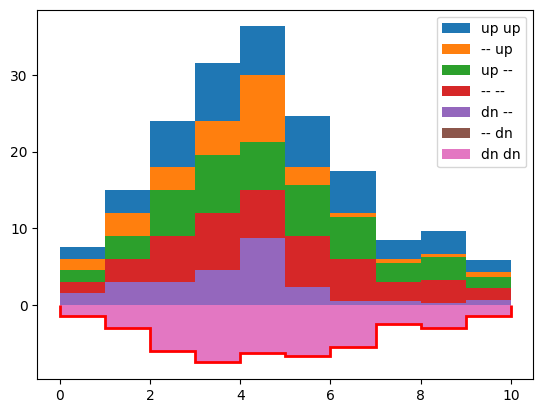

In [357]:
plt.stairs(hist2+hist1+hist2, bins, fill = True, label = 'up up')
plt.stairs(hist2+hist2, bins, fill = True, label = '-- up')
plt.stairs(hist2+hist1, bins, fill = True, label = 'up --')
plt.stairs(hist2, bins, fill=True, label = '-- --')
plt.stairs(hist2-hist1, bins, fill=True, label = 'dn --')
plt.stairs(hist2-hist2, bins, fill=True, label = '-- dn')
plt.stairs(hist2-hist1-hist2, bins, fill=True, label = 'dn dn')

initial_parameters = new_model.config.suggested_init()
initial_parameters[0] = 1.
initial_parameters[1] = 0.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()

# Correlations across samples

In [101]:
# add correlated parameters to pyhf model
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist1-hist1),
                    "hi_data": list(hist1+hist1)
                }
            }
        ],
        
    },    
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist1),
                    "hi_data": list(hist2+hist1)
                }
            }
        ],
        
    },
    
]
spec = {"channels" : [{"name" : "corrchannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [102]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}
new_spec = decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found
[(0, 0, 1), (0, 1, 0)]


ValueError: Correlated modifiers must have the same type.

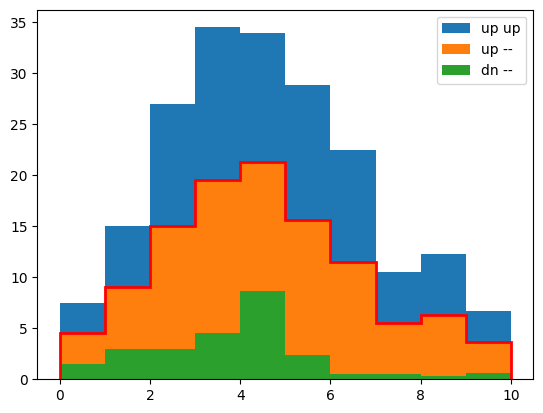

In [93]:
plt.stairs(hist2+hist1+hist1+hist1, bins, fill = True, label = 'up up')
# plt.stairs(hist2+hist2, bins, fill = True, label = '-- up')
plt.stairs(hist2+hist1, bins, fill = True, label = 'up --')
# plt.stairs(hist2, bins, fill=True, label = '-- --')
plt.stairs(hist2-hist1, bins, fill=True, label = 'dn --')
# plt.stairs(hist2-hist2, bins, fill=True, label = '-- dn')
# plt.stairs(hist2-hist1-hist2, bins, fill=True, label = 'dn dn')

initial_parameters = model.config.suggested_init()
initial_parameters[0] = 0.
# initial_parameters[1] = 1.

plt.stairs(model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()